In [1]:
import numpy as np
from astroplan import AirmassConstraint, AtNightConstraint, SequentialScheduler, ObservingBlock, PriorityScheduler
from astroplan.plots import plot_schedule_airmass
from matplotlib import pyplot as plt
from sqlalchemy import create_engine

from astrosa.assess.const import MAX_PRIORITY
from utils import *

engine = create_engine('sqlite:///astrosa/data/astrosa.sqlite', echo=False)
conn = engine.connect()

In [2]:
date_string = observing_date.strftime("%Y_%m_%d_%H_%M_%S")
# Chech if table exist. if exist jump to next step. 如果当前日期的表已经存在，就不再创建
if not engine.dialect.has_table(conn, f"rise_in_night_{date_string}"):

    engine_tyc2 = create_engine('sqlite:///astrosa/data/tyc2.sqlite', echo=False)
    conn_tyc2 = engine_tyc2.connect()

    # Create table
    # Get tycho stars
    limit_magnitude = 8
    tycho = pd.read_sql_query(f"SELECT * FROM tyc2 WHERE VTmag < {limit_magnitude}", con=conn_tyc2, chunksize=2000)
    for chunk in tycho:
        tycho_skycoord = SkyCoord(ra=chunk.RA_ICRS_.to_numpy() * u.deg, dec=chunk.DE_ICRS_.to_numpy() * u.deg,
                                  frame='icrs')
        target = FixedTarget(coord=tycho_skycoord, name=chunk.ID)

        tycho_rise_time = observer.target_rise_time(obs_start, target, which='next', horizon=30 * u.deg)
        # print(tycho_rise_time)

        visible_star = chunk.loc[tycho_rise_time < obs_end].copy()

        visible_star['rise_time'] = tycho_rise_time[tycho_rise_time < obs_end].datetime

        visible_star.to_sql(f"rise_in_night_{date_string}", con=conn, if_exists='append', index=False)

else:
    print(f"Table rise_in_night_{date_string} already exist, skip this step.")


Table rise_in_night_2023_06_08_00_00_00 already exist, skip this step.


In [3]:
candidate_table_name = f"candidate_{date_string}"
# 获取当前日期可见的恒星,随机取出100个
if not engine.dialect.has_table(conn, candidate_table_name):
    visible_star = pd.read_sql_query(f"SELECT * FROM rise_in_night_{date_string}", con=conn)

    candidates = visible_star.sample(100, random_state=42)
    candidates['priority'] = np.random.randint(1, MAX_PRIORITY + 1, size=len(candidates))
    candidates['exposure_minutes'] = 5
    candidates.to_sql(f"candidate_{date_string}", con=conn, if_exists='replace', index=False)


else:
    candidates = pd.read_sql_query(f"SELECT * FROM {candidate_table_name}", con=conn)

    print(f"Table {candidate_table_name} already exist, skip this step.")

candidates_icrs = SkyCoord(ra=candidates.RA_ICRS_.to_numpy() * u.deg, dec=candidates.DE_ICRS_.to_numpy() * u.deg,
                           frame='icrs')
print(len(candidates_icrs))

Table candidate_2023_06_08_00_00_00 already exist, skip this step.
100


In [4]:
# 恒星转为观测快,每个观测块5分钟
blocks = []
for star, name, p, (_, v) in zip(candidates_icrs, candidates.ID, candidates.priority, candidates.iterrows()):
    target = FixedTarget(coord=star, name=name)

    b = ObservingBlock(target, 5 * u.min, priority=p)
    blocks.append(b)

    # print(star, v.rise_time, p)

In [5]:
from astrosa.assess import Transitioner

# create the list of constraints that all targets must satisfy
global_constraints = [AirmassConstraint(max=3, boolean_constraint=False),
                      AtNightConstraint.twilight_astronomical()]

slew_rate = 3 * u.deg / u.second  # 1.2M 最大转速是 6 deg/s
transitioner = Transitioner([6 * u.deg / u.second, 6 * u.deg / u.second],
                            [1 * u.deg / u.second ** 2, 1 * u.deg / u.second ** 2],
                            slew_rate,
                            {'filter': {('B', 'G'): 10 * u.second,
                                        ('G', 'R'): 10 * u.second,
                                        'default': 30 * u.second}})



In [6]:
schedule = Schedule(obs_start, obs_end)
priority_scheduler = PriorityScheduler(constraints=global_constraints,
                                       observer=observer,
                                       transitioner=transitioner)
priority_scheduler(blocks, schedule)

Schedule containing 40 observing blocks between 2023-06-08 13:35:16.683 and 2023-06-08 17:32:01.974

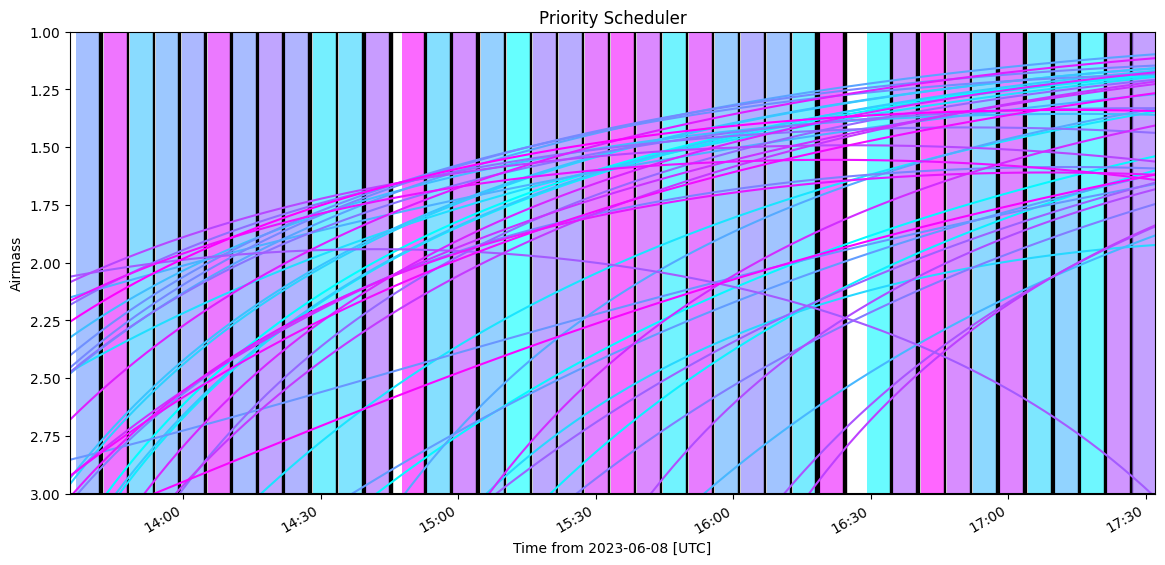

In [7]:
# plot the schedule with the airmass of the targets
plt.figure(figsize=(14, 6))
plot_schedule_airmass(schedule)
# plt.legend(loc="upper right")
plt.title(f"Priority Scheduler")
plt.show()

In [8]:
x = schedule2df_ex(schedule)

In [9]:
x.to_sql(f"priority_schedule_{date_string}", con=conn, if_exists='replace', index=False)

40

In [10]:
seq_scheduler = SequentialScheduler(constraints=global_constraints,
                                    observer=observer,
                                    transitioner=transitioner)

schedule = Schedule(obs_start, obs_end)
seq_scheduler(blocks, schedule)


Schedule containing 45 observing blocks between 2023-06-08 13:35:16.683 and 2023-06-08 17:32:01.974

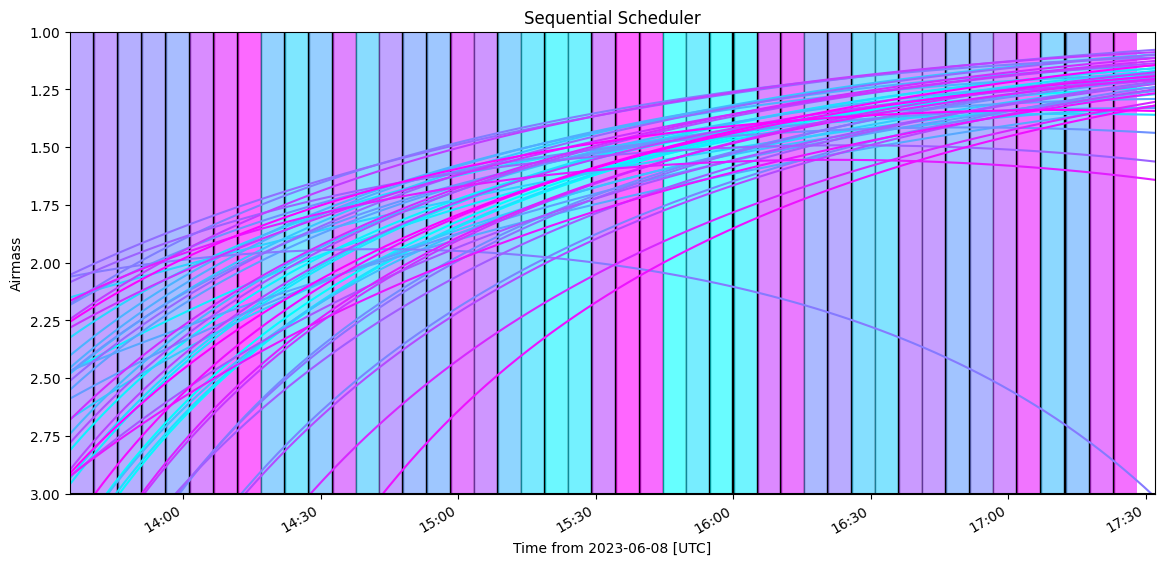

In [11]:
# plot the schedule with the airmass of the targets
plt.figure(figsize=(14, 6))
plot_schedule_airmass(schedule)
# plt.legend(loc="upper right")
plt.title(f"Sequential Scheduler")
plt.show()

In [12]:
x = schedule2df_ex(schedule)
x.to_sql(f"sequential_schedule_{date_string}", con=conn, if_exists='replace', index=False)


45

In [13]:
conn.commit()
conn.close()